# Reana-SPL Data Analysis

This repository contains execution data and analysis for persistent variations of the [Reana-SPL](https://github.com/SPLMC/reana-spl) tool.

# SPL Analysis Approach

Reana-SPL performs a product-line reliability analysis on a variety of software-product-lines.

To leverage the commonality among different products in order to speed up analysis,
we use a [feature-family-based analysis](https://www.infosun.fim.uni-passau.de/publications/docs/LCA+17ist.pdf). Instead of enumerating products and analyzing
them one-by-one (product-based analysis), we analyze features in isolation
and exploit the commonality among products to get results for the entire
product space more efficiently.

We analyze the data of three approaches to handling the evolved models.
- Non-evolution-aware: The analysis tool does not do any
  special handling of evolved models (`reana`)
- Evolution-aware without reordering: The analysis tool handles evolved models
  by reusing ADDs generated in previous runs.
  ADDs are only automatically reordered in the first run (`reanaEord`).
- Evolution-aware with reordering: Same as the above, but ADDs are reordered
  automatically at each iteration (`reanaE`).

We expect the non-evolution-aware analysis to perform the worst, with
both evolution-aware approaches obtaining similar results.
There is a tradeoff to ADD reordering: while it is expensive, it obtains
smaller ADDs on which operations are easier to perform.

# Data 

The data used contains runtime information for different variations of the
[Reana-SPL](https://github.com/SPLMC/reana-spl) product line analysis tool.
Different approaches are implemented in different branches of the main repository.
The main difference in the implementations is in the handling of ADD persistence.
The non-evolution-aware does not save its generated ADDs nor does it read ADDs
from previous executions, as is done in the evolution-aware implementations.

We execute an evolution scenario on the initial models of 6 different product
lines (BSN, Email, IC, Lift, MP, TW).
Each evolution doubles the amount of products to be analyzed.
Each model is evolved in a fixed manner up to 22 times, so we have an
increase in the product space of up to \(2^21\)-fold


In [193]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [194]:
import numpy as np
import pandas as pd
from IPython.display import display, Markdown
from utils import concat
from data_reader import *
from plotting import *
from stats import *
from tabulator import *
from display import *

# Running and Displaying Results

In [195]:
# This cells converts .out files to .csv
spls = ['BSN', 'Email', 'Lift', 'IC', 'MP', 'TW']
labels = ['Reana', 'ReanaE']

data_dir = 'message-data'
start_index = 1

rt_data = concat([['running_time/totalTime{}{}'.format(spl, label) for spl in spls] for label in labels])
mem_data = concat([['memory_usage/totalMemory{}{}'.format(spl, label) for spl in spls] for label in labels])

for filename in rt_data:
    out_to_csv('{}/{}.out'.format(data_dir, filename), 'csv/{}.csv'.format(filename))

for filename in mem_data:
       out_to_csv('{}/{}.out'.format(data_dir, filename), 'csv/{}.csv'.format(filename))

# BSN

## Running Time

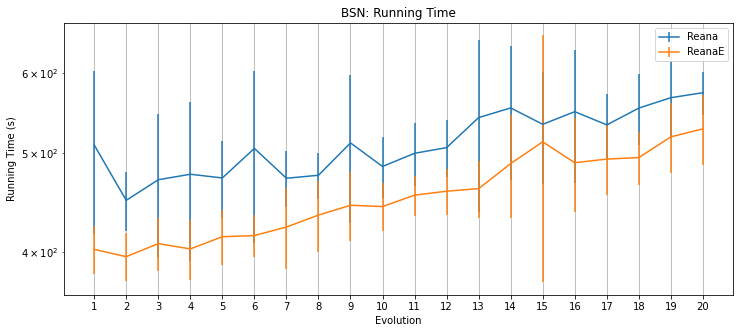

/Users/breno/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/breno/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/boxplot.py:380: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  ax = boxplot(


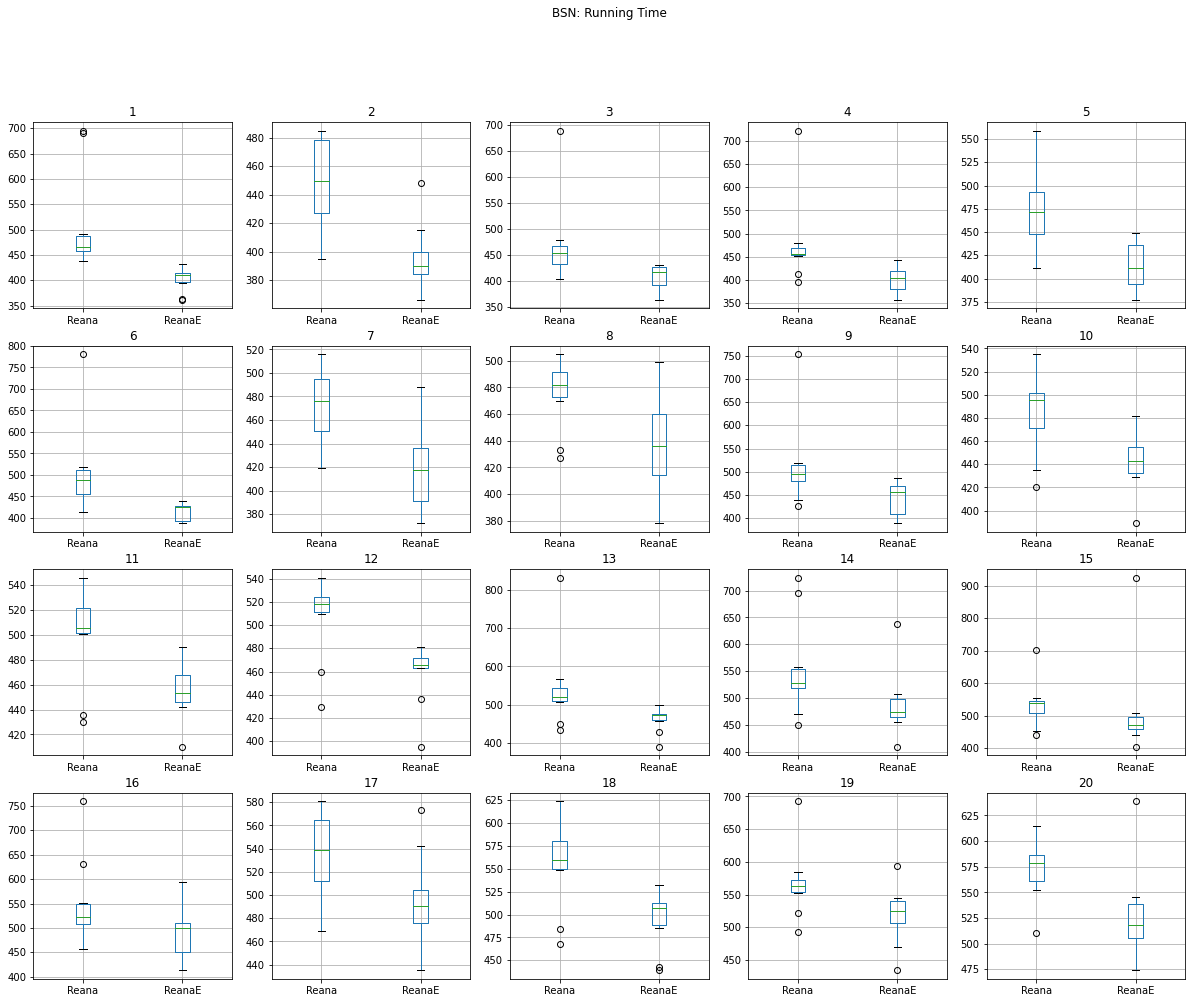

Average running time (s) (statistically smallest value in bold)

| Type | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 |
|---|---|---|---|---|---|---|---|---|---|---|
| Reana | 509.50 | 449.40 | 470.90 | 476.80 | 472.80 | 505.60 | 472.50 | 475.70 | 511.90 | 485.30 |
| ReanaE | **402.10** | **395.50** | **407.40** | **402.50** | **413.80** | **414.90** | **423.00** | **434.60** | **444.40** | **443.10** |
| --- | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 | 20 |
| Reana | 500.00 | 506.50 | 542.20 | 554.20 | 534.00 | 549.50 | 533.30 | 554.00 | 567.20 | 573.70 |
| ReanaE | **454.70** | **458.80** | **461.50** | 488.50 | 513.20 | 489.40 | 493.50 | **495.20** | 519.00 | **528.50** |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Reana | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| ReanaE | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
|---|---|---|---|---|---|---|---|---|---|---|


## Memory Usage

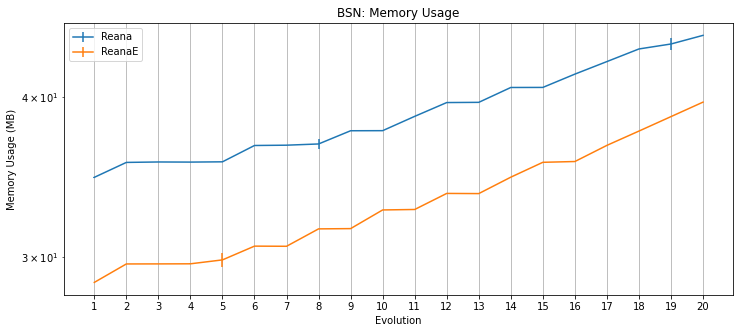

/Users/breno/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/breno/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/boxplot.py:380: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  ax = boxplot(


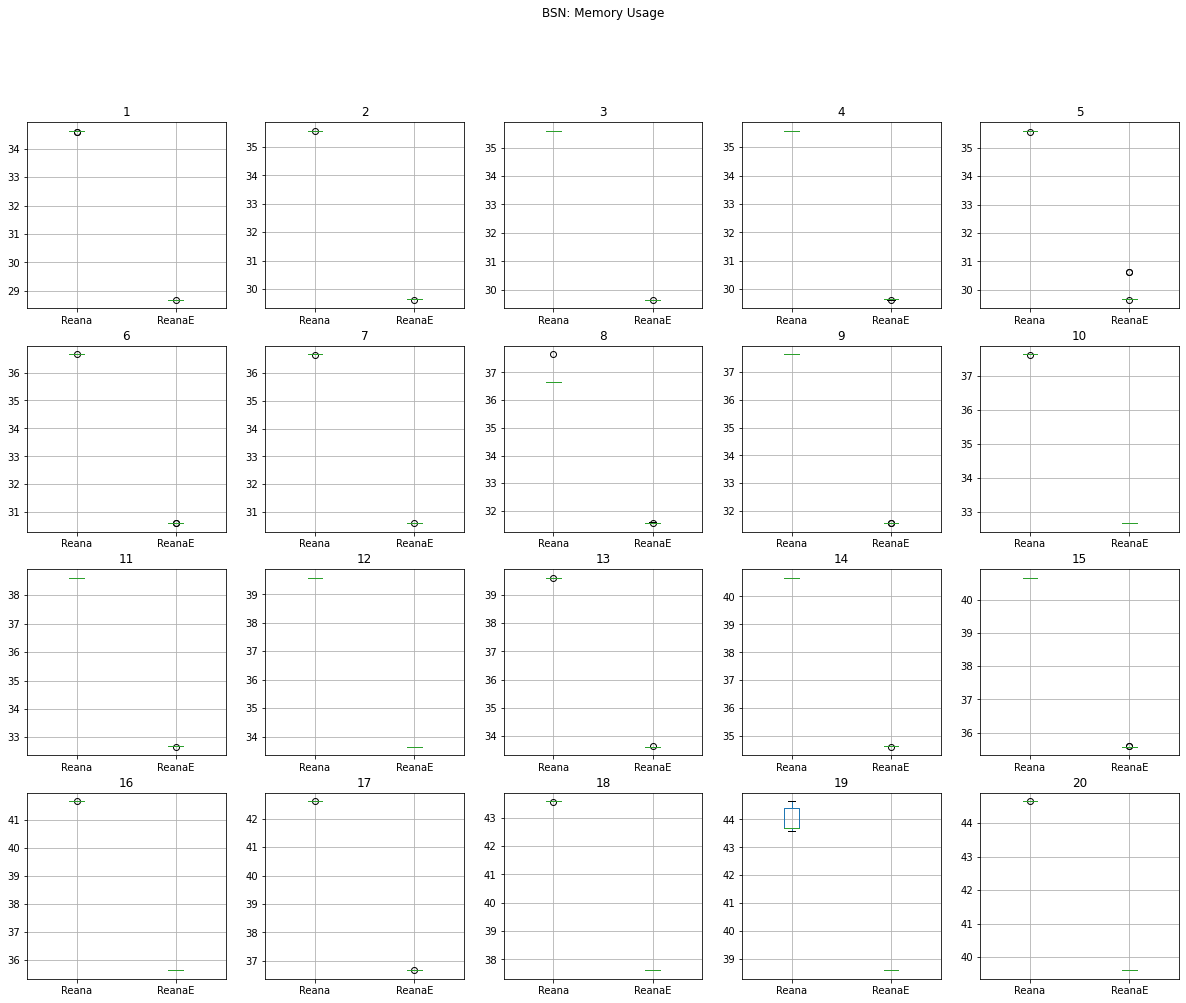

Average memory usage (MB) (statistically smallest value in bold)

| Type | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 |
|---|---|---|---|---|---|---|---|---|---|---|
| Reana | 34.62 | 35.56 | 35.59 | 35.58 | 35.60 | 36.66 | 36.68 | 36.76 | 37.64 | 37.64 |
| ReanaE | **28.68** | **29.64** | **29.65** | **29.65** | **29.86** | **30.61** | **30.60** | **31.57** | **31.58** | **32.66** |
| --- | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 | 20 |
| Reana | 38.62 | 39.59 | 39.60 | 40.67 | 40.68 | 41.66 | 42.61 | 43.58 | 43.97 | 44.66 |
| ReanaE | **32.68** | **33.64** | **33.63** | **34.63** | **35.57** | **35.62** | **36.67** | **37.62** | **38.61** | **39.62** |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Reana | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| ReanaE | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
|---|---|---|---|---|---|---|---|---|---|---|


/Users/breno/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


,Model,Reana Runtime (s),std1,ReanaE Runtime (s),std2,H0,Effect Size,Reana Memory Usage (MB),std1,ReanaE Memory Usage (MB),std2,H0,Effect Size
1,BSN 1,509.5,92.75,402.1,22.15,Reject,Large,34.62,1.47e-02,28.68,2.34e-03,Reject,Large
2,BSN 2,449.4,30.23,395.5,21.52,Reject,Large,35.56,2.65e-03,29.64,8.78e-03,Reject,Large
3,BSN 3,470.9,75.83,407.4,24.55,Reject,Large,35.59,0.00e+00,29.65,7.32e-05,Reject,Large
4,BSN 4,476.8,85.34,402.5,27.49,Reject,Large,35.58,0.00e+00,29.65,1.68e-02,Reject,Large
5,BSN 5,472.8,41.21,413.8,25.43,Reject,Large,35.60,9.86e-03,29.86,3.75e-01,Reject,Large
6,BSN 6,505.6,97.61,414.9,19.90,Reject,Large,36.66,1.37e-05,30.61,2.40e-03,Reject,Large
7,BSN 7,472.5,29.77,423.0,38.66,Reject,Large,36.68,4.68e-03,30.60,8.34e-03,Reject,Large
8,BSN 8,475.7,24.56,434.6,34.65,Reject,Large,36.76,3.01e-01,31.57,1.05e-02,Reject,Large
9,BSN 9,511.9,85.45,444.4,35.05,Reject,Large,37.64,0.00e+00,31.58,7.67e-03,Reject,Large
10,BSN 10,485.3,33.59,443.1,24.03,Reject,Large,37.64,6.43e-03,32.66,0.00e+00,Reject,Large


In [199]:
plot_spl('BSN', labels, start_index=1)

# Email

## Running Time

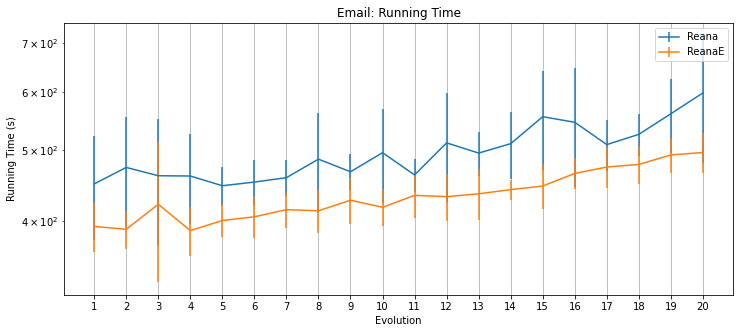

/Users/breno/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/breno/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/boxplot.py:380: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  ax = boxplot(


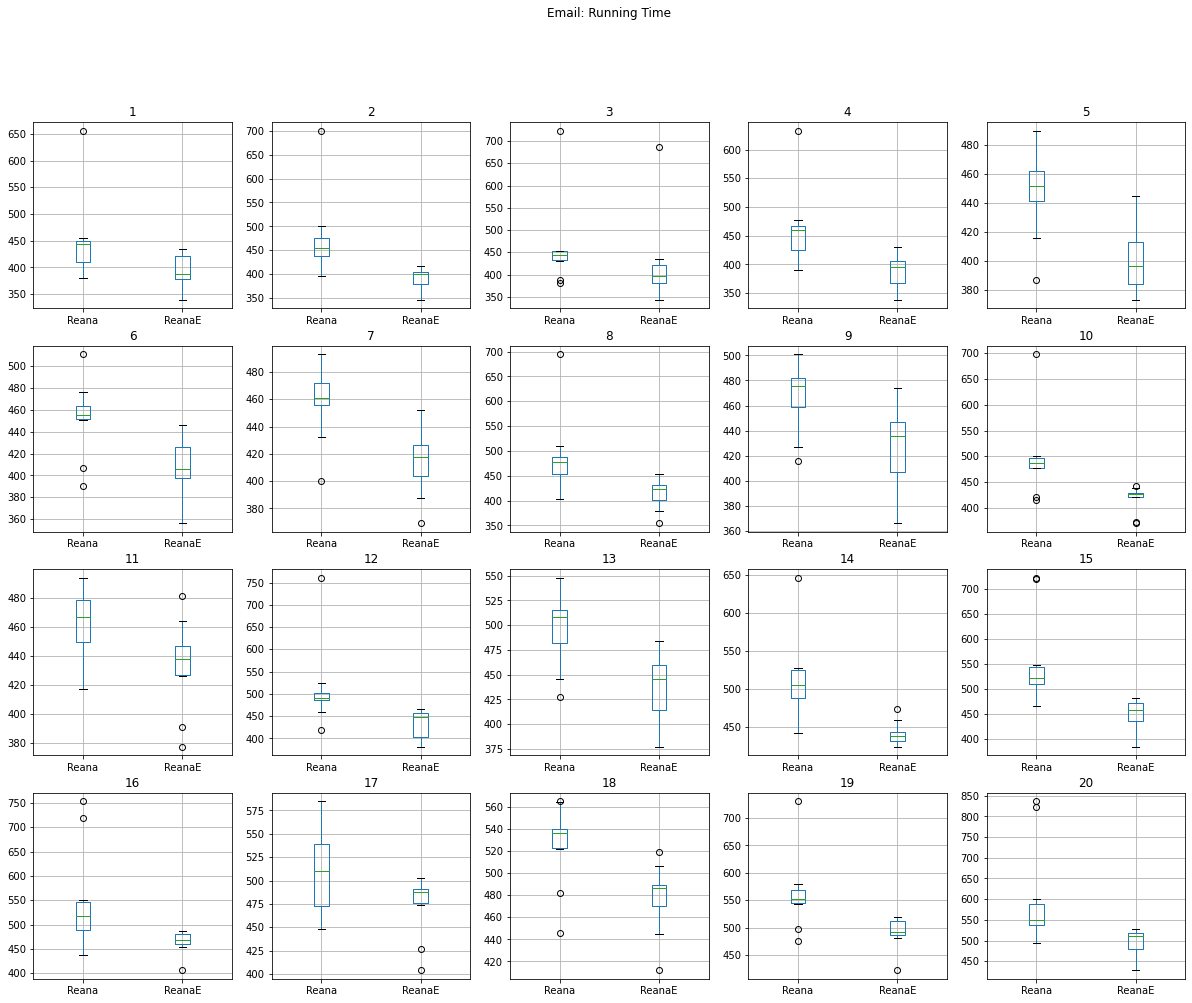

Average running time (s) (statistically smallest value in bold)

| Type | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 |
|---|---|---|---|---|---|---|---|---|---|---|
| Reana | 449.70 | 473.60 | 461.40 | 461.00 | 447.10 | 452.30 | 458.60 | 486.10 | 467.20 | 496.10 |
| ReanaE | **393.40** | **389.80** | 421.80 | **388.20** | **400.80** | **405.50** | **414.70** | **413.20** | **427.20** | **417.80** |
| --- | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 | 20 |
| Reana | 462.60 | 511.70 | 495.50 | 510.40 | 555.60 | 545.90 | 508.90 | 525.60 | 560.80 | 598.80 |
| ReanaE | 433.80 | **432.00** | **435.90** | **441.70** | **446.70** | **464.80** | 474.20 | **478.10** | **492.60** | 496.40 |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Reana | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| ReanaE | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
|---|---|---|---|---|---|---|---|---|---|---|


## Memory Usage

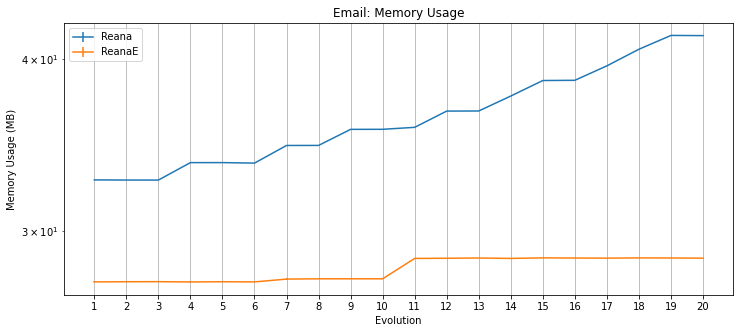

/Users/breno/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/breno/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/boxplot.py:380: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  ax = boxplot(


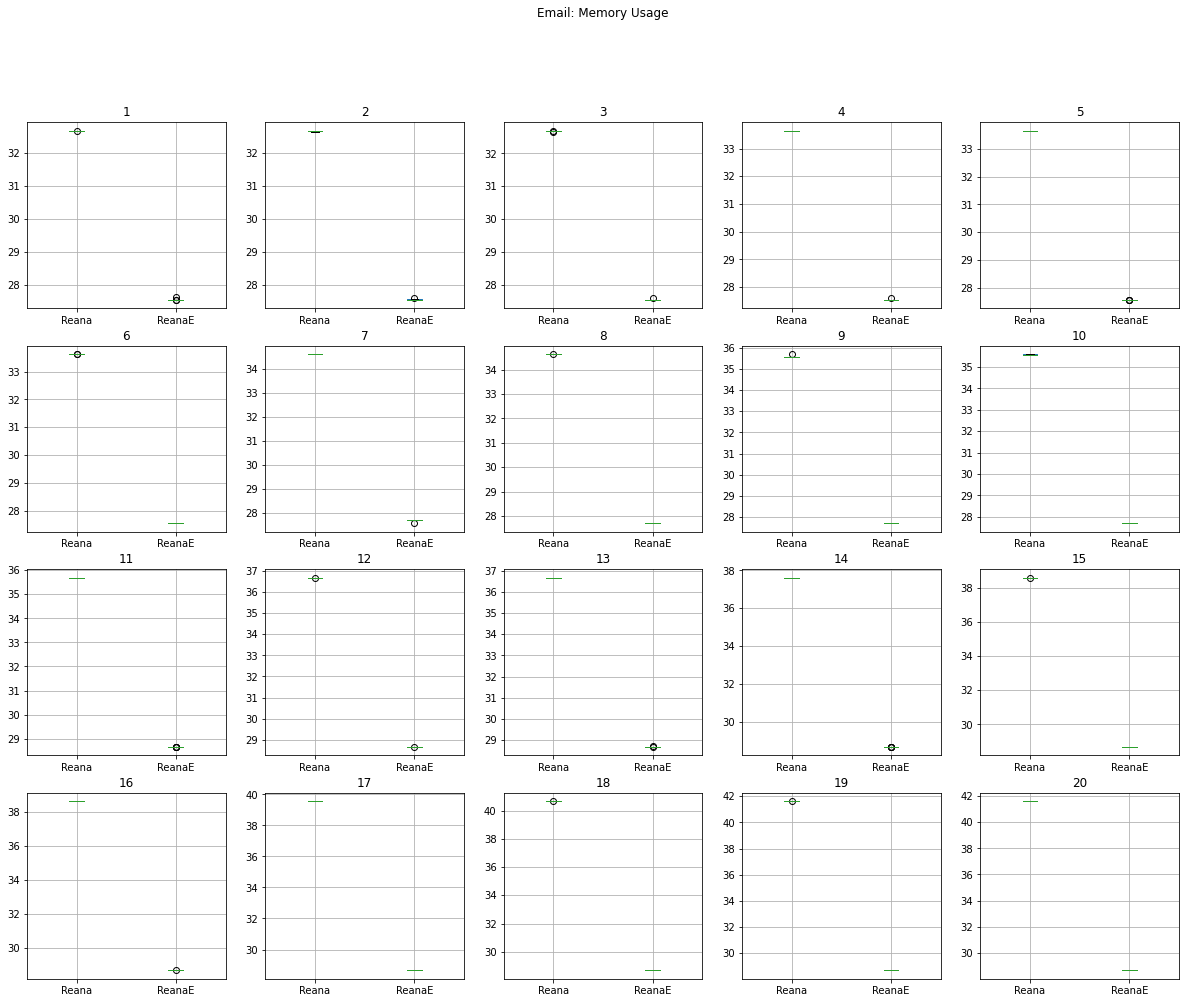

Average memory usage (MB) (statistically smallest value in bold)

| Type | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 |
|---|---|---|---|---|---|---|---|---|---|---|
| Reana | 32.69 | 32.68 | 32.68 | 33.65 | 33.65 | 33.62 | 34.63 | 34.63 | 35.57 | 35.58 |
| ReanaE | **27.55** | **27.56** | **27.56** | **27.55** | **27.56** | **27.55** | **27.68** | **27.70** | **27.70** | **27.70** |
| --- | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 | 20 |
| Reana | 35.70 | 36.68 | 36.69 | 37.62 | 38.61 | 38.62 | 39.57 | 40.69 | 41.64 | 41.62 |
| ReanaE | **28.66** | **28.66** | **28.68** | **28.66** | **28.68** | **28.68** | **28.67** | **28.68** | **28.68** | **28.67** |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Reana | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| ReanaE | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
|---|---|---|---|---|---|---|---|---|---|---|


/Users/breno/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


,Model,Reana Runtime (s),std1,ReanaE Runtime (s),std2,H0,Effect Size,Reana Memory Usage (MB),std1,ReanaE Memory Usage (MB),std2,H0,Effect Size
1,Email 1,449.7,72.77,393.4,30.54,Reject,Medium,32.69,3.66e-05,27.55,2.14e-02,Reject,Large
2,Email 2,473.6,80.72,389.8,22.89,Reject,Large,32.68,1.26e-02,27.56,1.65e-02,Reject,Large
3,Email 3,461.4,90.70,421.8,92.00,Not Reject,--,32.68,7.09e-03,27.56,1.52e-02,Reject,Large
4,Email 4,461.0,64.70,388.2,30.00,Reject,Large,33.65,0.00e+00,27.55,2.23e-02,Reject,Large
5,Email 5,447.1,27.37,400.8,20.68,Reject,Large,33.65,5.46e-03,27.56,3.09e-03,Reject,Large
6,Email 6,452.3,31.89,405.5,26.38,Reject,Large,33.62,2.39e-03,27.55,4.30e-03,Reject,Large
7,Email 7,458.6,25.64,414.7,22.91,Reject,Large,34.63,0.00e+00,27.68,3.80e-02,Reject,Large
8,Email 8,486.1,76.35,413.2,28.01,Reject,Large,34.63,2.31e-03,27.70,0.00e+00,Reject,Large
9,Email 9,467.2,26.21,427.2,30.49,Reject,Large,35.57,4.03e-02,27.70,0.00e+00,Reject,Large
10,Email 10,496.1,73.21,417.8,24.20,Reject,Large,35.58,1.34e-02,27.70,0.00e+00,Reject,Large


In [200]:
plot_spl('Email', labels, start_index=1)

# Lift

## Running Time

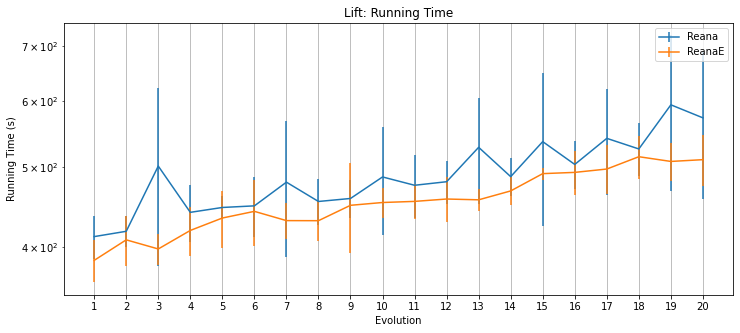

/Users/breno/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/breno/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/boxplot.py:380: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  ax = boxplot(


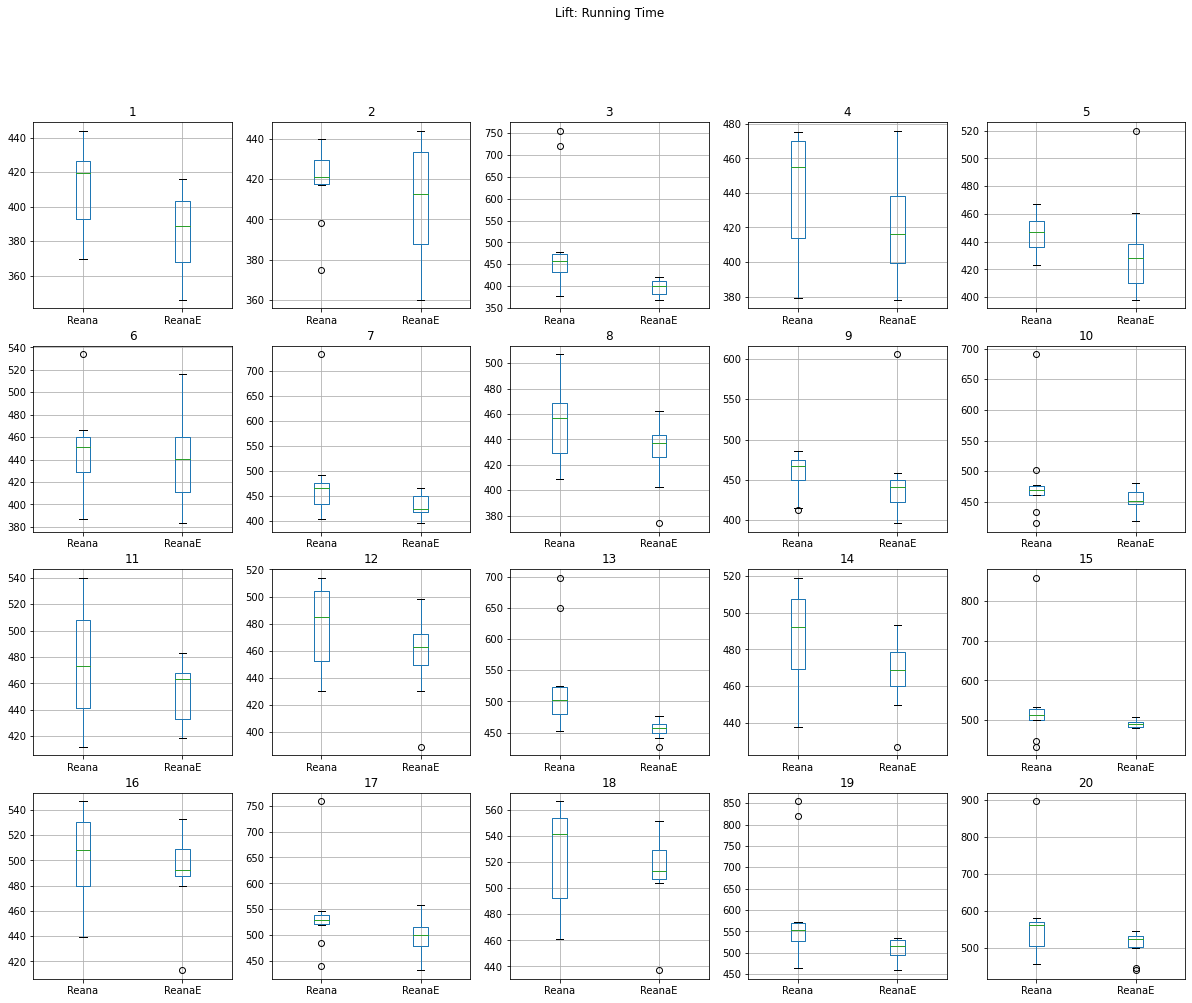

Average running time (s) (statistically smallest value in bold)

| Type | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 |
|---|---|---|---|---|---|---|---|---|---|---|
| Reana | 411.70 | 417.80 | 500.80 | 440.40 | 446.40 | 448.40 | 478.90 | 453.90 | 457.70 | 485.90 |
| ReanaE | 385.40 | 408.00 | 397.80 | 418.80 | 433.50 | 441.60 | 430.40 | 430.30 | 449.10 | 452.60 |
| --- | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 | 20 |
| Reana | 474.80 | 479.50 | 527.60 | 486.30 | 536.00 | 503.10 | 540.90 | 525.20 | 593.70 | 572.60 |
| ReanaE | 454.00 | 457.00 | 456.00 | 467.40 | 490.40 | 492.10 | 496.70 | 514.00 | 507.30 | 509.80 |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Reana | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| ReanaE | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
|---|---|---|---|---|---|---|---|---|---|---|


## Memory Usage

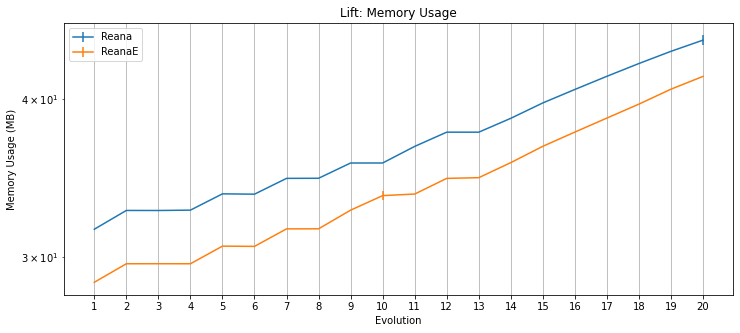

/Users/breno/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/breno/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/boxplot.py:380: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  ax = boxplot(


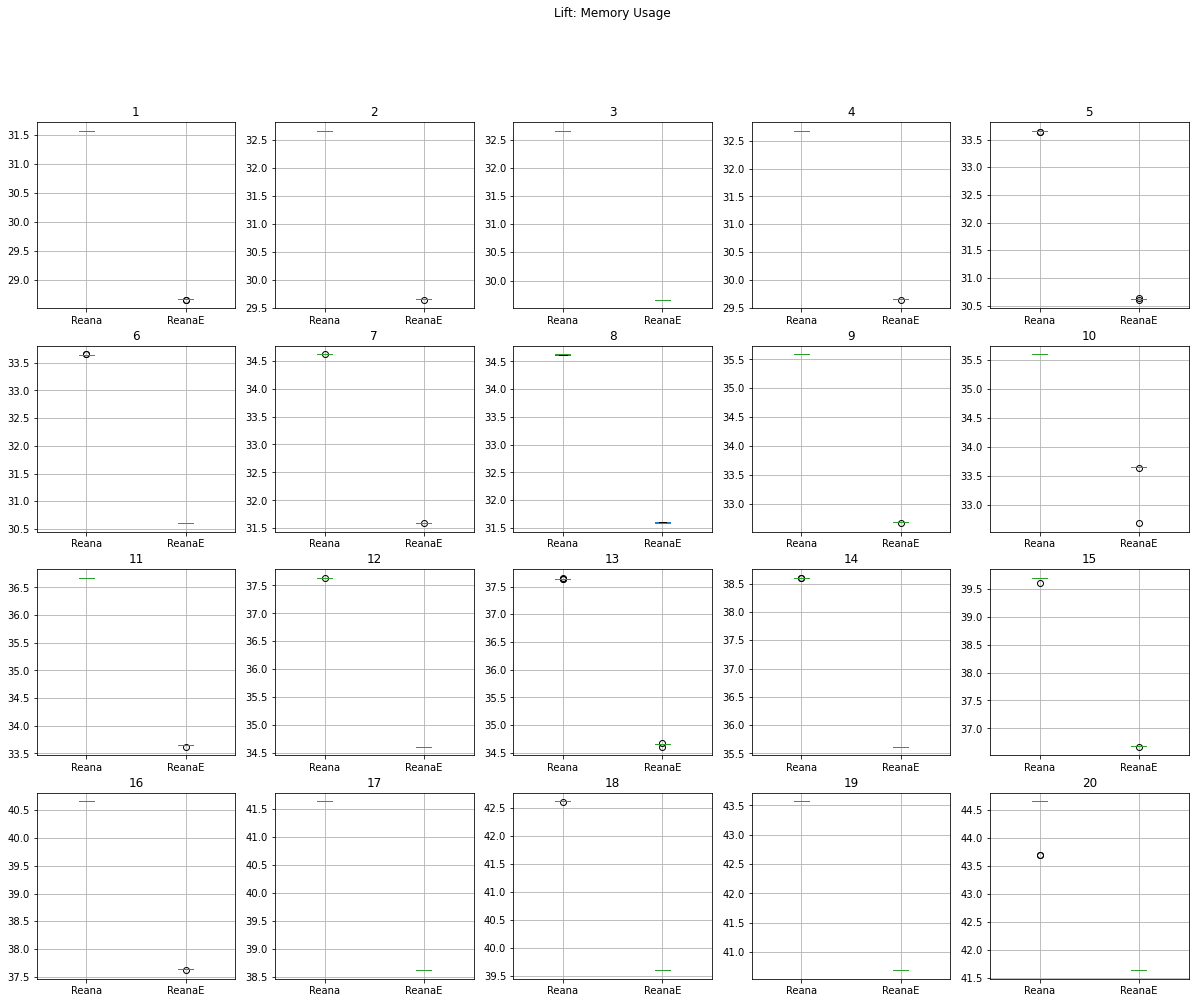

Average memory usage (MB) (statistically smallest value in bold)

| Type | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 |
|---|---|---|---|---|---|---|---|---|---|---|
| Reana | 31.57 | 32.66 | 32.66 | 32.68 | 33.66 | 33.64 | 34.61 | 34.62 | 35.59 | 35.59 |
| ReanaE | **28.67** | **29.65** | **29.65** | **29.65** | **30.61** | **30.60** | **31.59** | **31.59** | **32.68** | **33.55** |
| --- | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 | 20 |
| Reana | 36.68 | 37.64 | 37.64 | 38.59 | 39.69 | 40.67 | 41.65 | 42.62 | 43.57 | 44.47 |
| ReanaE | **33.65** | **34.61** | **34.66** | **35.62** | **36.69** | **37.64** | **38.61** | **39.60** | **40.69** | **41.64** |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Reana | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| ReanaE | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
|---|---|---|---|---|---|---|---|---|---|---|


/Users/breno/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


,Model,Reana Runtime (s),std1,ReanaE Runtime (s),std2,H0,Effect Size,Reana Memory Usage (MB),std1,ReanaE Memory Usage (MB),std2,H0,Effect Size
1,Lift 1,411.7,24.69,385.4,22.94,Not Reject,--,31.57,5.22e-03,28.67,8.58e-03,Reject,Large
2,Lift 2,417.8,17.76,408.0,28.30,Not Reject,--,32.66,0.00e+00,29.65,4.69e-03,Reject,Large
3,Lift 3,500.8,121.71,397.8,16.94,Not Reject,--,32.66,0.00e+00,29.65,0.00e+00,Reject,Large
4,Lift 4,440.4,34.88,418.8,28.80,Not Reject,--,32.68,0.00e+00,29.65,4.62e-03,Reject,Large
5,Lift 5,446.4,14.32,433.5,34.21,Not Reject,--,33.66,9.18e-03,30.61,6.97e-03,Reject,Large
6,Lift 6,448.4,37.69,441.6,40.86,Not Reject,--,33.64,8.55e-03,30.60,3.69e-03,Reject,Large
7,Lift 7,478.9,89.37,430.4,21.84,Not Reject,--,34.61,2.56e-04,31.59,2.43e-03,Reject,Large
8,Lift 8,453.9,28.62,430.3,23.79,Not Reject,--,34.62,1.15e-02,31.59,9.11e-03,Reject,Large
9,Lift 9,457.7,24.32,449.1,56.00,Not Reject,--,35.59,0.00e+00,32.68,6.41e-03,Reject,Large
10,Lift 10,485.9,72.01,452.6,19.22,Not Reject,--,35.59,0.00e+00,33.55,2.90e-01,Reject,Large


In [201]:
plot_spl('Lift', labels, start_index=1)

# IC

## Running Time

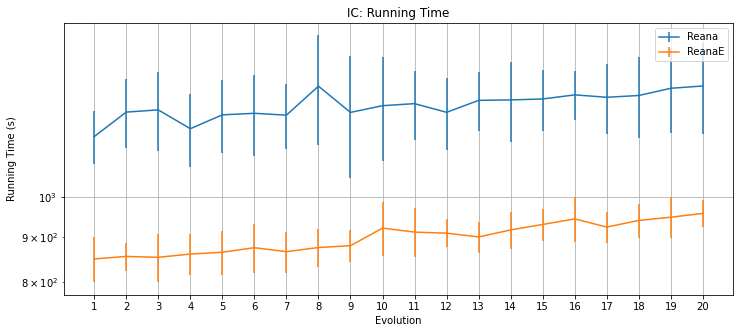

/Users/breno/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/breno/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/boxplot.py:380: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  ax = boxplot(


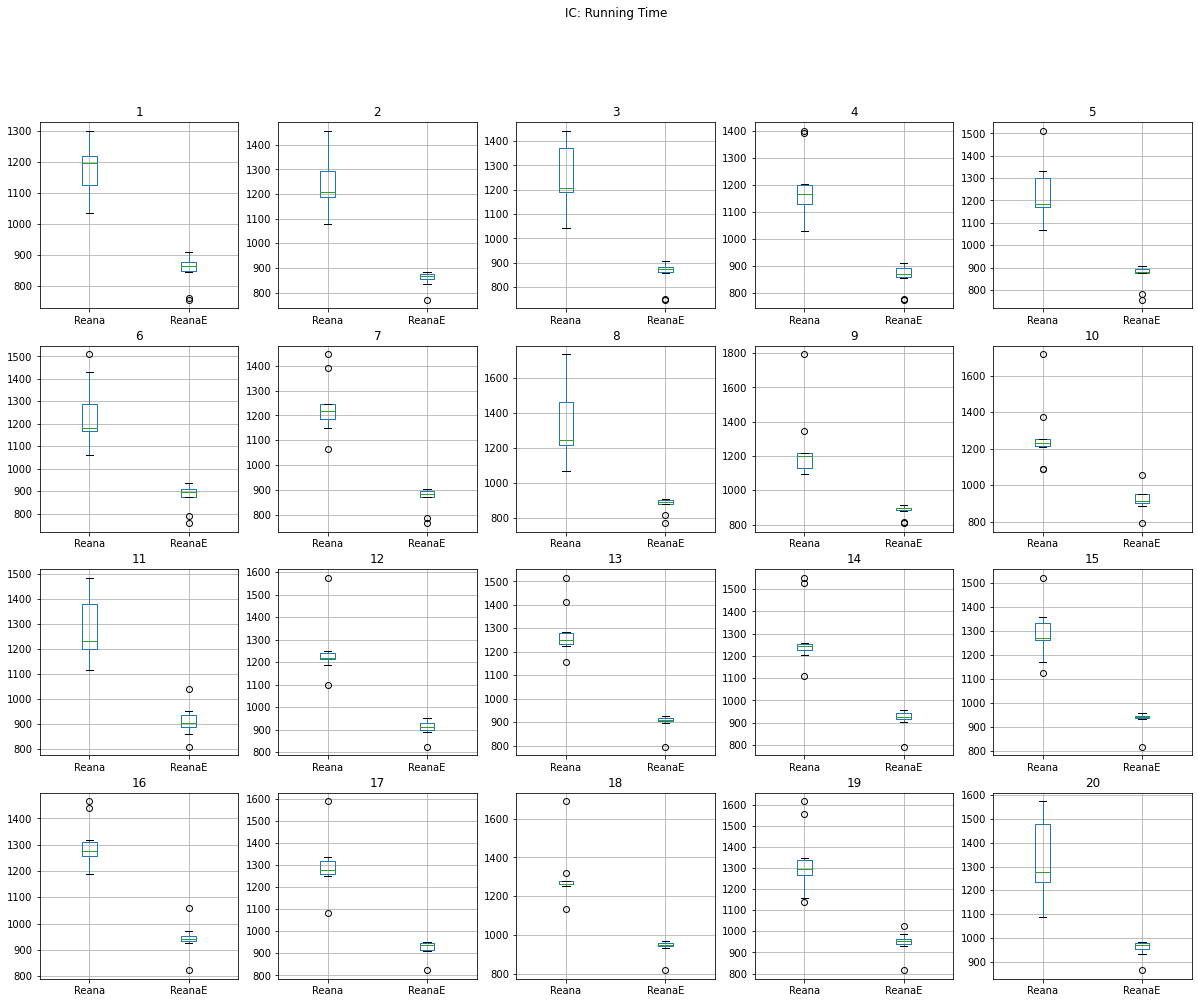

Average running time (s) (statistically smallest value in bold)

| Type | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 |
|---|---|---|---|---|---|---|---|---|---|---|
| Reana | 1168.80 | 1245.80 | 1253.00 | 1193.10 | 1236.90 | 1241.90 | 1235.90 | 1332.80 | 1244.80 | 1266.80 |
| ReanaE | **850.20** | **855.70** | **853.80** | **861.00** | **865.10** | **875.40** | **866.40** | **875.80** | **879.90** | **921.20** |
| --- | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 | 20 |
| Reana | 1273.50 | 1245.10 | 1284.40 | 1285.90 | 1289.10 | 1302.90 | 1294.80 | 1300.80 | 1325.50 | 1333.40 |
| ReanaE | **911.60** | **909.10** | **900.20** | **916.80** | **930.00** | **943.50** | **923.60** | **939.80** | **947.70** | **957.10** |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Reana | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| ReanaE | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
|---|---|---|---|---|---|---|---|---|---|---|


## Memory Usage

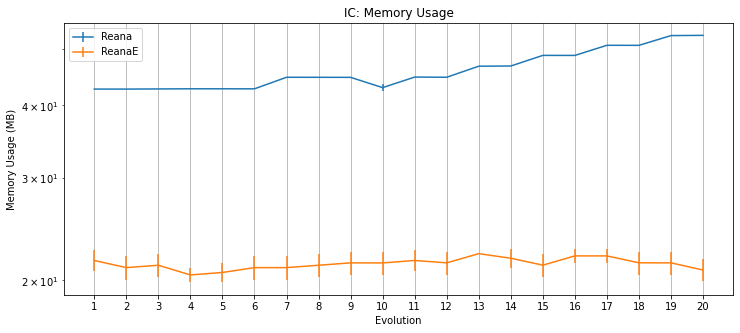

/Users/breno/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/breno/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/boxplot.py:380: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  ax = boxplot(


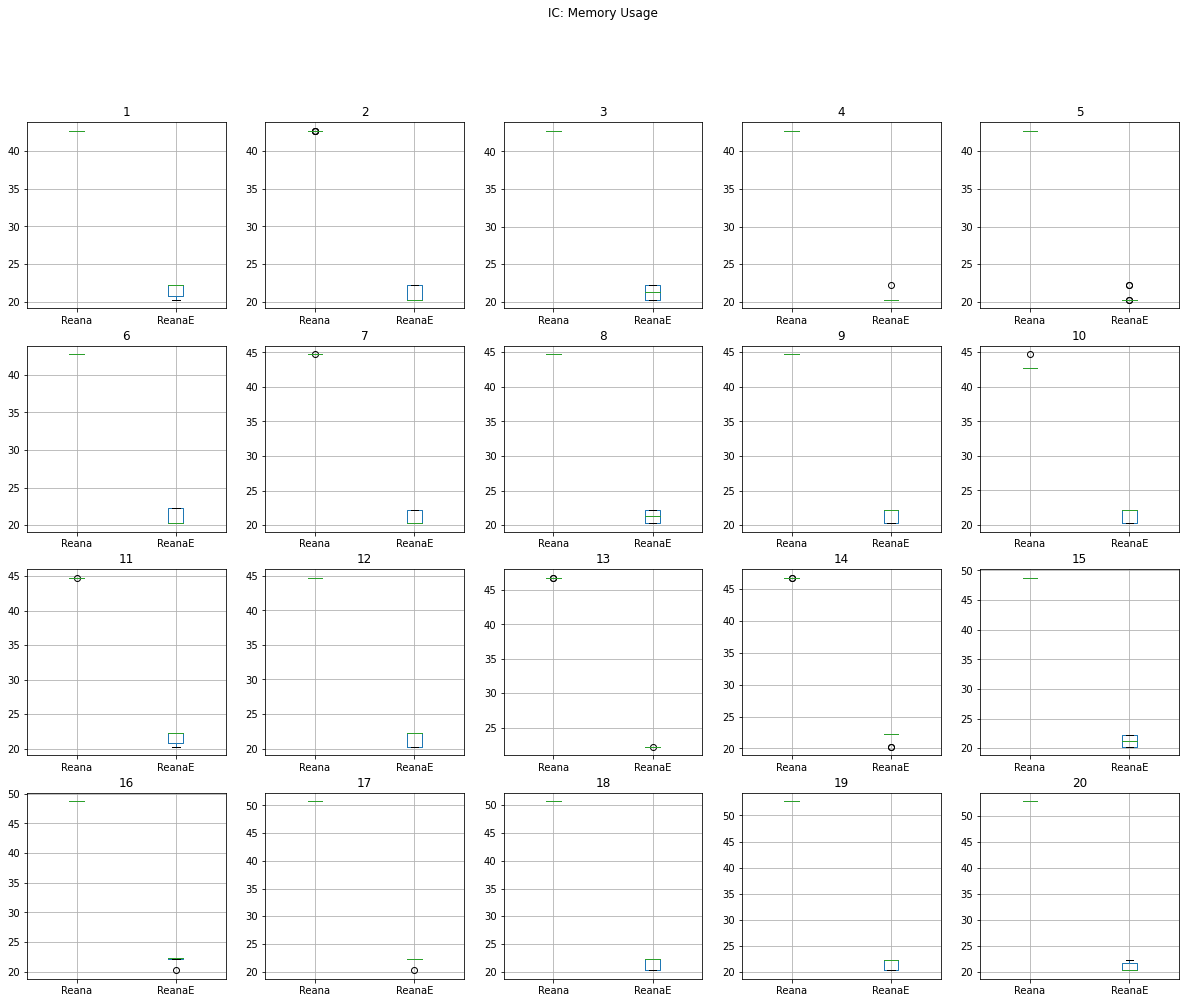

Average memory usage (MB) (statistically smallest value in bold)

| Type | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 |
|---|---|---|---|---|---|---|---|---|---|---|
| Reana | 42.69 | 42.69 | 42.71 | 42.74 | 42.74 | 42.73 | 44.73 | 44.72 | 44.72 | 42.94 |
| ReanaE | **21.65** | **21.05** | **21.24** | **20.44** | **20.65** | **21.05** | **21.05** | **21.24** | **21.44** | **21.44** |
| --- | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 | 20 |
| Reana | 44.77 | 44.74 | 46.74 | 46.77 | 48.78 | 48.78 | 50.77 | 50.76 | 52.76 | 52.81 |
| ReanaE | **21.65** | **21.45** | **22.24** | **21.84** | **21.25** | **22.05** | **22.04** | **21.45** | **21.45** | **20.85** |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Reana | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| ReanaE | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
|---|---|---|---|---|---|---|---|---|---|---|


/Users/breno/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


,Model,Reana Runtime (s),std1,ReanaE Runtime (s),std2,H0,Effect Size,Reana Memory Usage (MB),std1,ReanaE Memory Usage (MB),std2,H0,Effect Size
1,IC 1,1168.8,79.87,850.2,50.49,Reject,Large,42.69,3.98e-03,21.65,9.19e-01,Reject,Large
2,IC 2,1245.8,110.75,855.7,31.56,Reject,Large,42.69,3.58e-03,21.05,9.78e-01,Reject,Large
3,IC 3,1253.0,128.11,853.8,53.78,Reject,Large,42.71,2.97e-02,21.24,1.00e+00,Reject,Large
4,IC 4,1193.1,112.95,861.0,45.10,Reject,Large,42.74,2.47e-03,20.44,5.98e-01,Reject,Large
5,IC 5,1236.9,117.83,865.1,49.69,Reject,Large,42.74,5.76e-03,20.65,8.00e-01,Reject,Large
6,IC 6,1241.9,130.44,875.4,54.96,Reject,Large,42.73,2.37e-03,21.05,9.80e-01,Reject,Large
7,IC 7,1235.9,104.85,866.4,46.39,Reject,Large,44.73,4.33e-03,21.05,9.76e-01,Reject,Large
8,IC 8,1332.8,188.36,875.8,43.50,Reject,Large,44.72,3.79e-03,21.24,9.99e-01,Reject,Large
9,IC 9,1244.8,195.84,879.9,36.04,Reject,Large,44.72,3.31e-03,21.44,9.80e-01,Reject,Large
10,IC 10,1266.8,169.75,921.2,63.76,Reject,Large,42.94,5.96e-01,21.44,9.81e-01,Reject,Large


In [202]:
plot_spl('IC', labels, start_index=1)

# MP

## Running Time

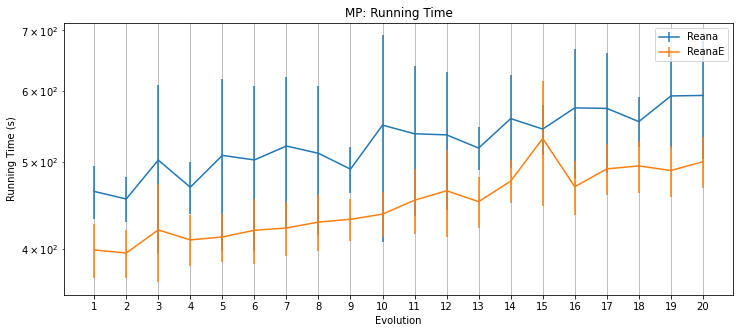

/Users/breno/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/breno/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/boxplot.py:380: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  ax = boxplot(


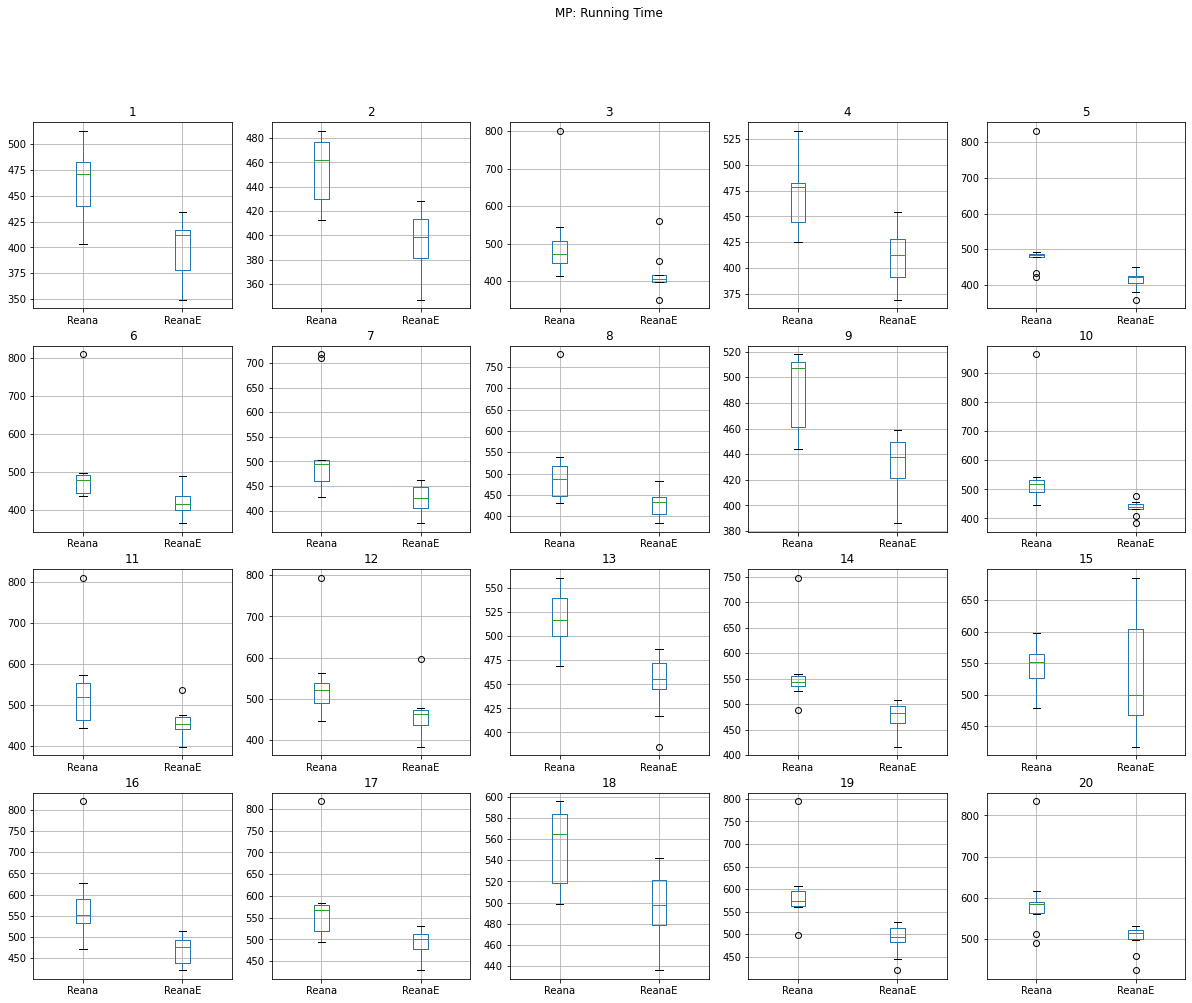

Average running time (s) (statistically smallest value in bold)

| Type | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 |
|---|---|---|---|---|---|---|---|---|---|---|
| Reana | 463.60 | 454.70 | 502.30 | 468.60 | 508.40 | 502.50 | 520.70 | 511.10 | 490.80 | 549.30 |
| ReanaE | **399.10** | **396.00** | **420.10** | **409.50** | **412.60** | **419.70** | 422.20 | **428.60** | **431.70** | **437.40** |
| --- | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 | 20 |
| Reana | 537.30 | 535.80 | 518.00 | 558.60 | 543.80 | 574.10 | 573.40 | 554.30 | 591.90 | 592.70 |
| ReanaE | **453.30** | 464.40 | **451.60** | **476.00** | 530.90 | **469.20** | **491.10** | **494.90** | **489.10** | **500.20** |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Reana | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| ReanaE | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
|---|---|---|---|---|---|---|---|---|---|---|


## Memory Usage

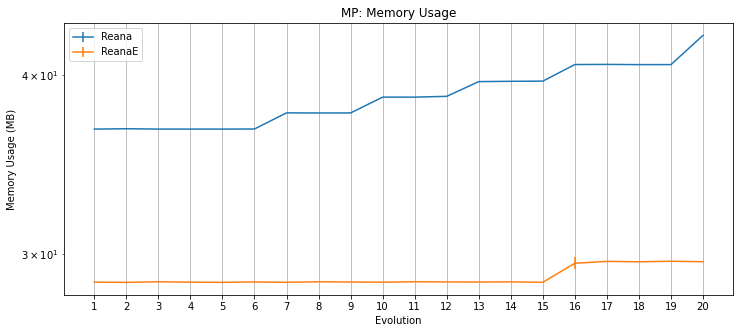

/Users/breno/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/breno/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/boxplot.py:380: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  ax = boxplot(


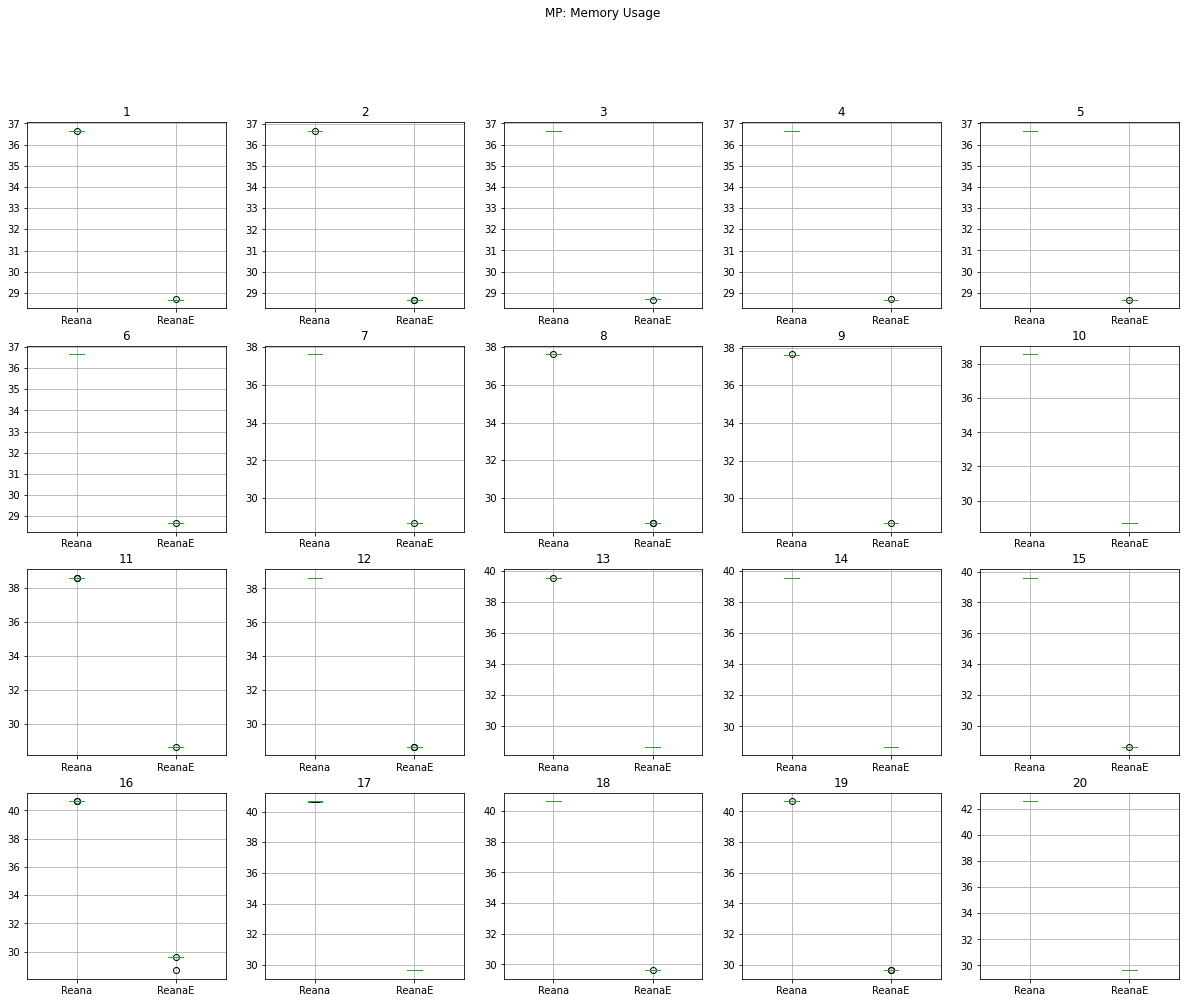

Average memory usage (MB) (statistically smallest value in bold)

| Type | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 |
|---|---|---|---|---|---|---|---|---|---|---|
| Reana | 36.66 | 36.68 | 36.66 | 36.66 | 36.66 | 36.66 | 37.63 | 37.62 | 37.62 | 38.59 |
| ReanaE | **28.67** | **28.66** | **28.68** | **28.67** | **28.66** | **28.68** | **28.66** | **28.68** | **28.67** | **28.66** |
| --- | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 | 20 |
| Reana | 38.59 | 38.64 | 39.56 | 39.58 | 39.59 | 40.66 | 40.67 | 40.66 | 40.66 | 42.61 |
| ReanaE | **28.69** | **28.68** | **28.67** | **28.68** | **28.66** | **29.55** | **29.64** | **29.62** | **29.65** | **29.62** |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Reana | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| ReanaE | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
|---|---|---|---|---|---|---|---|---|---|---|


/Users/breno/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


,Model,Reana Runtime (s),std1,ReanaE Runtime (s),std2,H0,Effect Size,Reana Memory Usage (MB),std1,ReanaE Memory Usage (MB),std2,H0,Effect Size
1,MP 1,463.6,31.47,399.1,27.32,Reject,Large,36.66,1.56e-04,28.67,7.02e-03,Reject,Large
2,MP 2,454.7,26.29,396.0,24.19,Reject,Large,36.68,2.33e-03,28.66,1.77e-03,Reject,Large
3,MP 3,502.3,106.64,420.1,52.84,Reject,Large,36.66,0.00e+00,28.68,8.79e-03,Reject,Large
4,MP 4,468.6,31.27,409.5,26.52,Reject,Large,36.66,0.00e+00,28.67,7.02e-03,Reject,Large
5,MP 5,508.4,110.24,412.6,25.47,Reject,Large,36.66,0.00e+00,28.66,1.72e-03,Reject,Large
6,MP 6,502.5,104.92,419.7,34.70,Reject,Large,36.66,0.00e+00,28.68,6.38e-03,Reject,Large
7,MP 7,520.7,100.10,422.2,28.95,Not Reject,--,37.63,9.77e-04,28.66,6.44e-03,Reject,Large
8,MP 8,511.1,96.20,428.6,30.88,Reject,Large,37.62,1.70e-03,28.68,8.77e-03,Reject,Large
9,MP 9,490.8,29.19,431.7,22.85,Reject,Large,37.62,1.11e-02,28.67,6.32e-03,Reject,Large
10,MP 10,549.3,141.92,437.4,25.05,Reject,Large,38.59,0.00e+00,28.66,9.85e-03,Reject,Large


In [203]:
plot_spl('MP', labels, start_index=1)

# TW

## Running Time

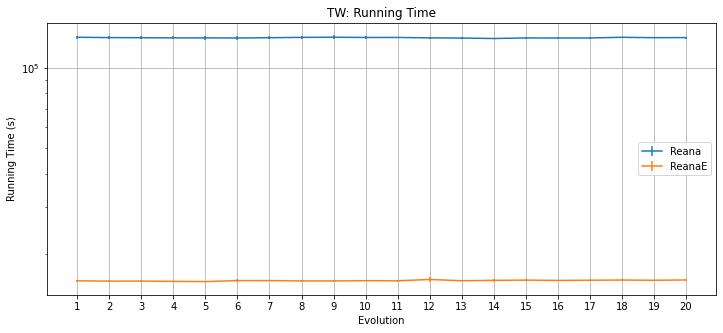

/Users/breno/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/breno/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/boxplot.py:380: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  ax = boxplot(


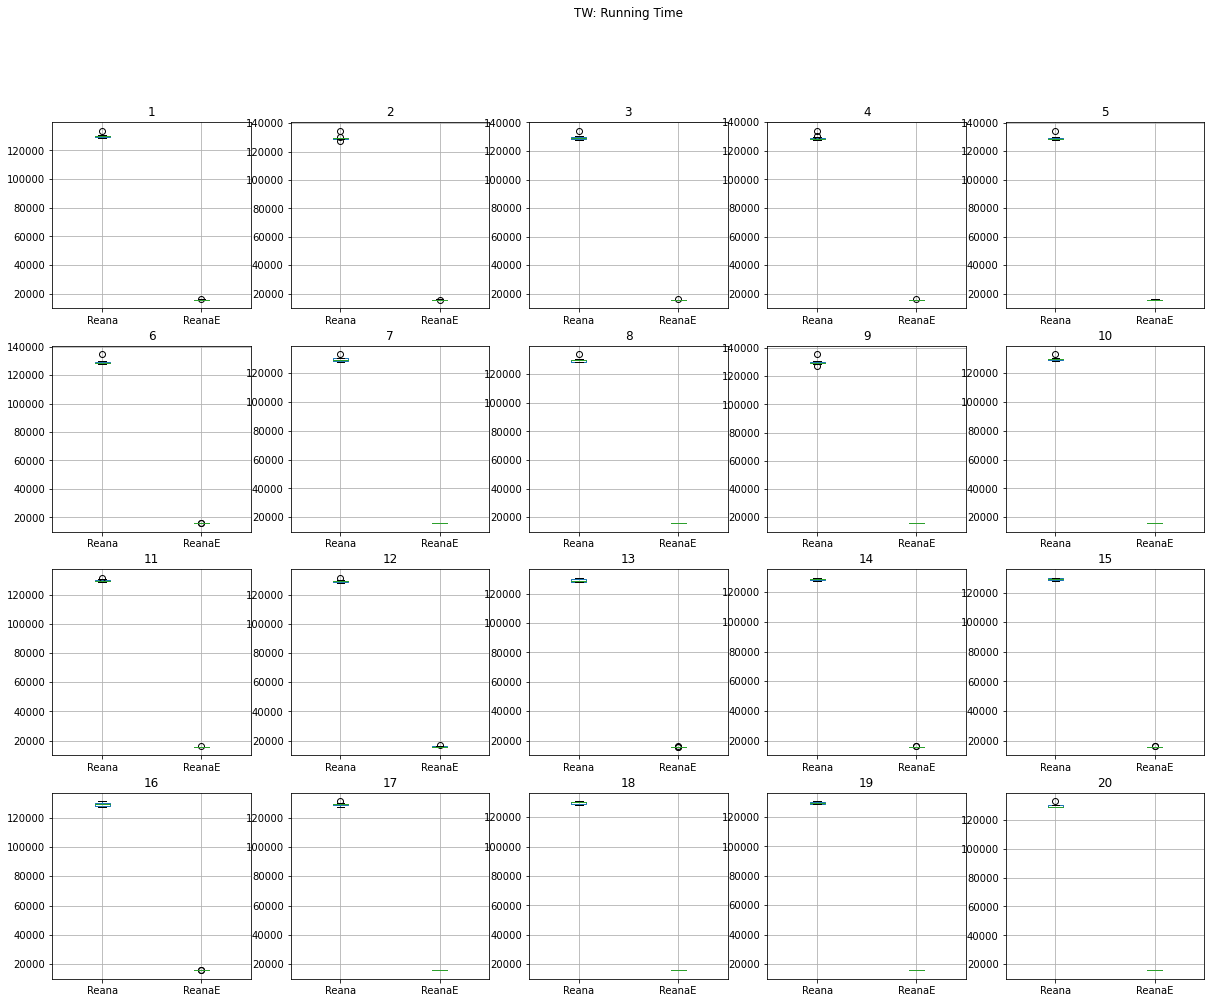

Average running time (s) (statistically smallest value in bold)

| Type | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 |
|---|---|---|---|---|---|---|---|---|---|---|
| Reana | 130003.20 | 129623.80 | 129483.60 | 129293.70 | 129298.50 | 129186.00 | 129477.30 | 129862.40 | 130035.20 | 129771.40 |
| ReanaE | **15822.70** | **15778.40** | **15784.90** | **15749.90** | **15711.30** | **15855.60** | **15846.90** | **15808.50** | **15806.00** | **15835.50** |
| --- | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 | 20 |
| Reana | 129787.90 | 129334.50 | 129099.90 | 128591.00 | 129223.90 | 129149.60 | 129190.50 | 129958.30 | 129530.90 | 129630.60 |
| ReanaE | **15822.80** | **16008.50** | **15829.20** | **15889.20** | **15914.60** | **15876.80** | **15899.70** | **15928.50** | **15897.00** | **15936.90** |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Reana | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| ReanaE | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
|---|---|---|---|---|---|---|---|---|---|---|


ParserError: Error tokenizing data. C error: Expected 9 fields in line 2, saw 11


In [204]:
plot_spl('TW', labels, start_index=1)